In [1]:
import os
from dotenv import load_dotenv
import praw
import praw
from datetime import datetime, timedelta
import pandas as pd
import re

# Ielādējiet vid=s mainīgos no .env faila
load_dotenv()

# Piešķiriet vides mainīgos
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')
user_agent = os.getenv('USER_AGENT')

# Izveidojiet Reddit instanci
reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=user_agent)

In [ ]:
# List of stock symbols and corresponding company names
stocks_info = {
    'MSFT': 'Microsoft',
    'AAPL': 'Apple',
    'NVDA': 'NVIDIA',
    'AMZN': 'Amazon',
    'GOOG': 'Google',
    'META': 'Meta Platforms',
    'LLY': 'Eli Lilly',
    'TSM': 'Taiwan Semiconductor',
    'AVGO': 'Broadcom',
    'V': 'Visa',
    'NVO': 'Novo Nordisk',
    'TSLA': 'Tesla',
    'WMT': 'Walmart',
    'XOM': 'Exxon Mobil',
    'MA': 'MasterCard',
    'UNH': 'UnitedHealth',
    'ASML': 'ASML Holding',
    'JNJ': 'Johnson & Johnson',
    'PG': 'Procter & Gamble'
}

# Date range
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 4, 7)

# Function to fetch comments within a specified date range
def fetch_comments(stock_symbol, company_name):
    subreddit = reddit.subreddit('stocks+investing+finance+wallstreetbets')
    comments_list = []
    search_query = f"{stock_symbol}|{company_name}"
    for submission in subreddit.search(search_query, limit=50):
        submission_date = datetime.fromtimestamp(submission.created_utc)
        if start_date <= submission_date <= end_date:
            submission.comments.replace_more(limit=0)
            for comment in submission.comments.list():
                comments_list.append({
                    'Date': submission_date.strftime('%Y-%m-%d'),
                    'Ticker': stock_symbol,
                    'Text': comment.body,
                    'Upvotes': comment.score,
                    'Title': submission.title
                })
    return comments_list

# Create DataFrame
df = pd.DataFrame(columns=['Date', 'Ticker', 'Text', 'Upvotes', 'Title'])

# Fetch and store comments for each stock
for symbol, name in stocks_info.items():
    comments = fetch_comments(symbol, name)
    df = pd.concat([df, pd.DataFrame(comments)])


In [90]:
df.sort_values(by = ['Ticker','Date']).head()

,Date,Ticker,Text,Upvotes,Title
1256,2023-09-19,AAPL,"Welcome to r/stocks!\n\nFor beginner advice, b...",1,Thoughts on apple AAPL and Astrazenica AZN?
1257,2023-09-19,AAPL,My guess is that AAPL will probably go up in t...,3,Thoughts on apple AAPL and Astrazenica AZN?
1258,2023-09-19,AAPL,"Or it may go up and down, or down and up....\n...",1,Thoughts on apple AAPL and Astrazenica AZN?
1259,2023-09-19,AAPL,>I'm not asking for a crystal ball. I just wan...,-5,Thoughts on apple AAPL and Astrazenica AZN?
1260,2023-09-19,AAPL,My brother is a mechanical engineer for APPL i...,1,Thoughts on apple AAPL and Astrazenica AZN?


In [9]:
df.Ticker.value_counts()

Ticker
NVDA    7250
MSFT    5619
META    4074
TSLA    3318
AAPL    2550
PG      1720
AMZN    1581
LLY     1501
GOOG    1458
TSM     1054
NVO     1010
AVGO     927
ASML     662
XOM      298
Name: count, dtype: int64

In [97]:
# List of tickers you are interested in
tickers = ['NVDA', 'MSFT', 'TSLA', 'AAPL', 'META', 'LLY', 'AMZN', 'TSM', 
           'PG', 'NVO', 'AVGO', 'GOOG', 'ASML', 'XOM']

# Filter the DataFrame to only contain rows where the Ticker is in the list of tickers
df = df[df['Ticker'].isin(tickers)]

In [99]:
df.to_csv('Reddit.csv')

In [82]:
import pandas as pd
df = pd.read_csv('Reddit.csv', index_col=0)

In [7]:
df.shape

(33022, 5)

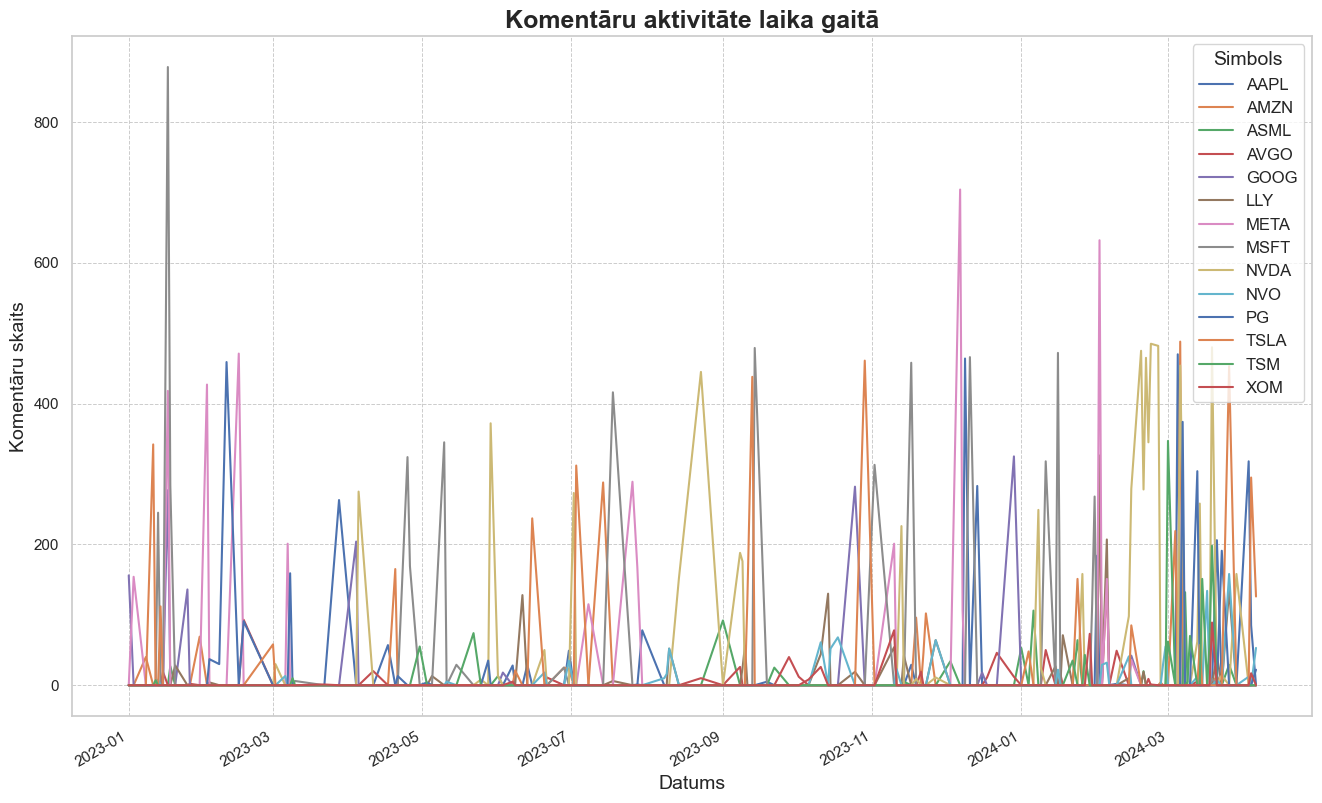

In [84]:
import matplotlib.pyplot as plt
# Nodrošinām, ka datuma kolonna ir datu formātā
df['Date'] = pd.to_datetime(df['Date'])

# Grupējam datus pa datumiem un simboliem
daily_activity = df.groupby(['Date', 'Ticker']).size().unstack(fill_value=0)

# Uzzīmējam aktivitātes grafiku ar lielāku izmēru un leģendu
fig, ax = plt.subplots(figsize=(16, 10))
daily_activity.plot(kind='line', ax=ax)

# Grafika pielāgošana
ax.set_title('Komentāru aktivitāte laika gaitā', fontsize=18, fontweight='bold')
ax.set_xlabel('Datums', fontsize=14)
ax.set_ylabel('Komentāru skaits', fontsize=14)

# Novieto leģendu labajā augšējā stūrī
ax.legend(title='Simbols', fontsize=12, title_fontsize=14, loc='upper right')

ax.grid(True, linestyle='--', linewidth=0.7)

# Parāda grafiku
plt.show()


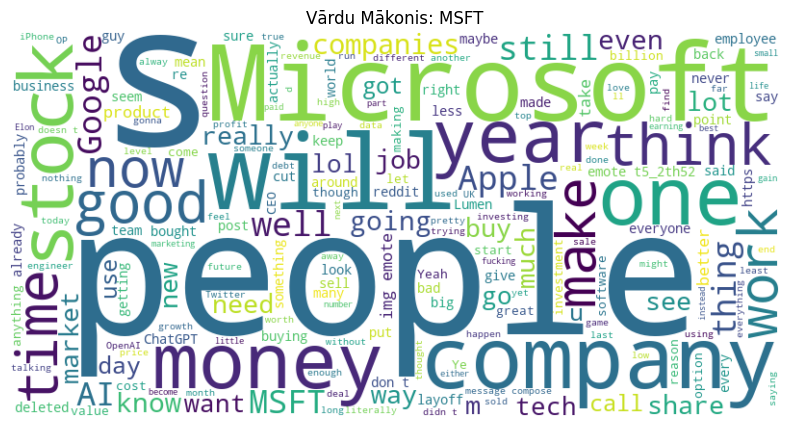

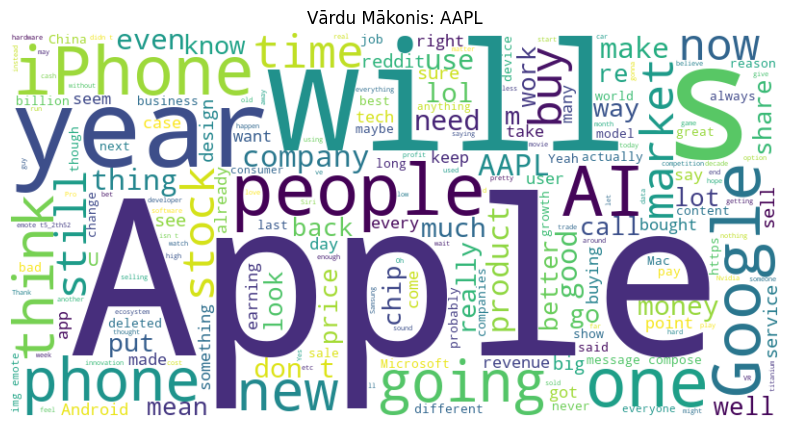

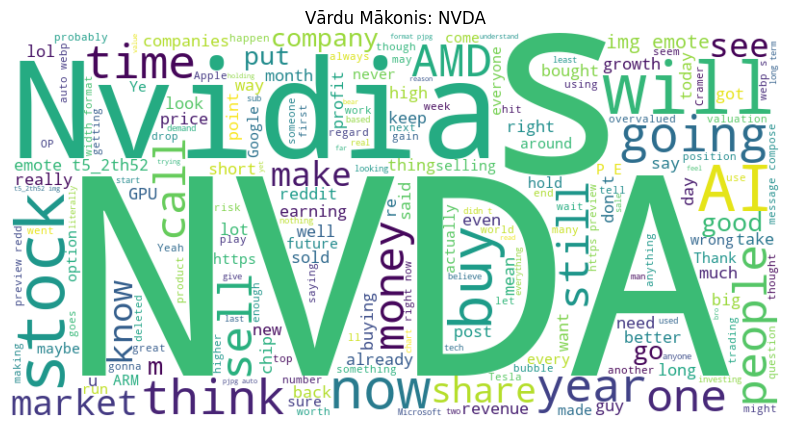

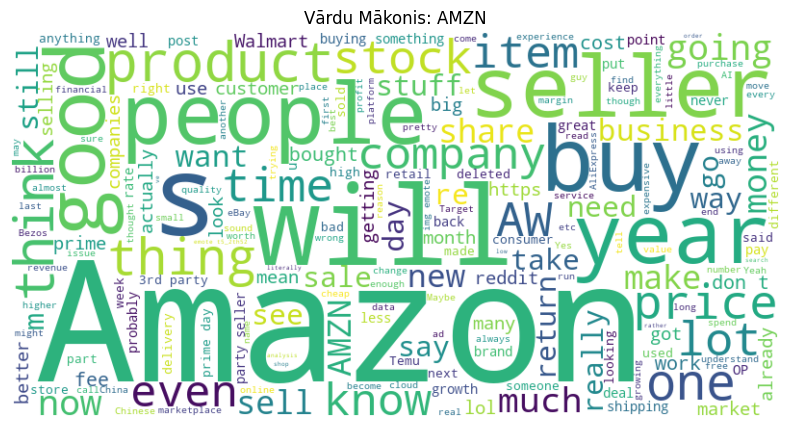

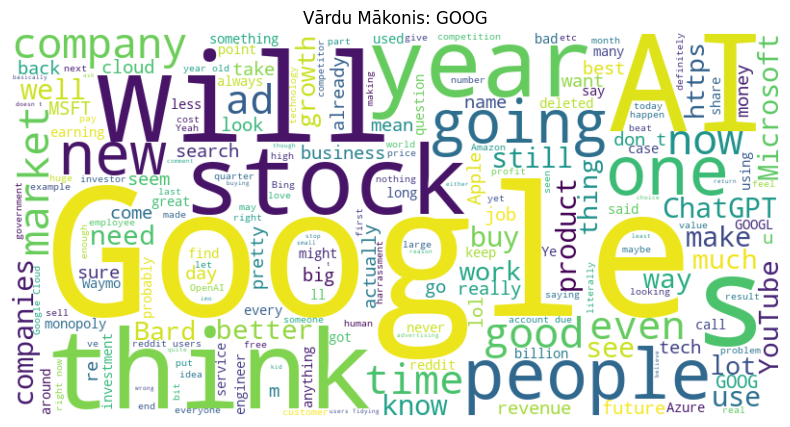

In [24]:
from wordcloud import WordCloud
# Pievieno nevēlamus vārdus sarakstam
banned_words = {
    'fuck', 'shit', 'damn' 
}

# Funkcija vārdu mākoņu veidošanai pēc simbola, ar filtriem
def generate_wordcloud(ticker):
    # Atlasam visus komentārus, kas saistīti ar konkrēto simbolu
    comments_text = ' '.join(df[df['Ticker'] == ticker]['Text'])
    # Teksta filtrēšana, izslēdzot nevēlamos vārdus
    filtered_text = ' '.join(word for word in comments_text.split() if word.lower() not in banned_words)
    # Vārdu mākoņa izveidošana
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)
    # Vārdu mākoņa attēlošana
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Vārdu Mākonis: {ticker}')
    plt.axis('off')
    plt.show()

# Izveidojam vārdu mākoņus visiem simboliem
for symbol in df['Ticker'].unique()[:5]:
    generate_wordcloud(symbol)

In [102]:
df.Ticker.value_counts()

Ticker
NVDA    7250
MSFT    5619
META    4074
TSLA    3318
AAPL    2550
PG      1720
AMZN    1581
LLY     1501
GOOG    1458
TSM     1054
NVO     1010
AVGO     927
ASML     662
XOM      298
Name: count, dtype: int64

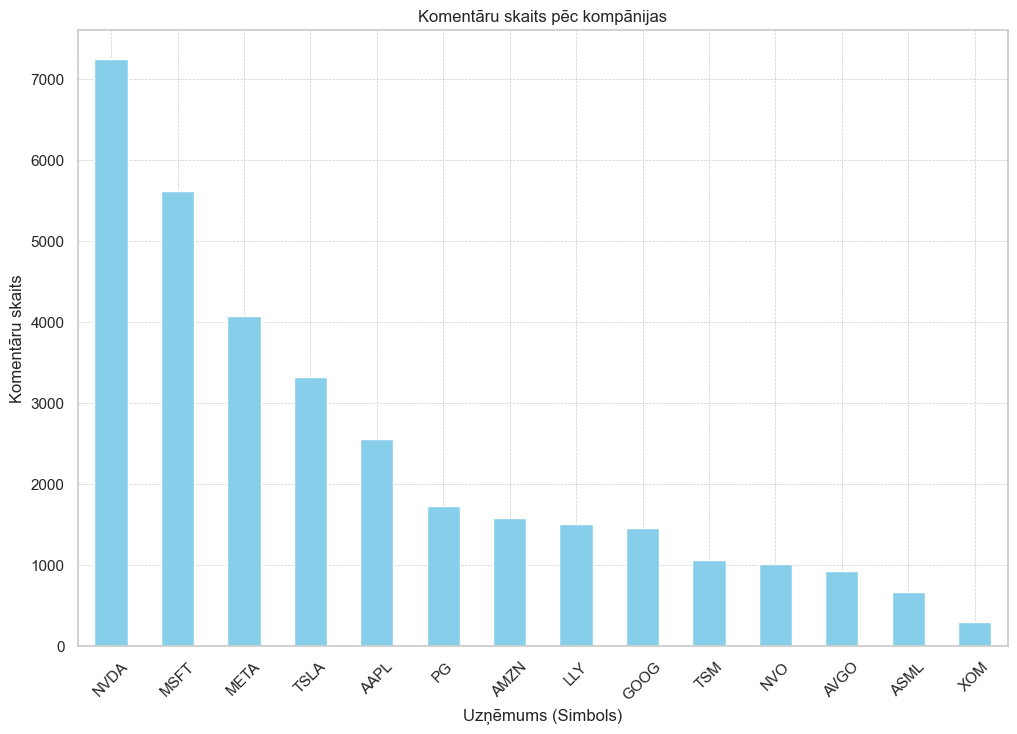

In [31]:
# Skaita, cik bieži katrs uzņēmuma simbols (Ticker) parādās DataFrame
ticker_counts = df['Ticker'].value_counts()

# Uzzīmējam stabiņu diagrammu ar komentāru skaitu katrai kompānijai
plt.figure(figsize=(12, 8))  # Iestatām diagrammas izmēru
ticker_counts.plot(kind='bar', color='skyblue')  # Veidojam stabiņu diagrammu

# Uzstādam diagrammas nosaukumu un asi nosaukumus
plt.title('Komentāru skaits pēc kompānijas')  # Diagrammas virsraksts
plt.xlabel('Uzņēmums (Simbols)')  # x ass nosaukums
plt.ylabel('Komentāru skaits')  # y ass nosaukums
plt.xticks(rotation=45)  # Pagriež kompāniju nosaukumus par 45 grādiem, lai tie būtu labāk lasāmi
plt.grid(True, linestyle='--', linewidth=0.5)  # Iestata režģi diagrammā

# Parādām diagrammu
plt.show()

In [116]:
df.sort_values(by=['Date', 'Upvotes'], ascending=[True, False], inplace=True)
df = df[df.Text != '[deleted]']

# Then, limit to 10 comments per day per stock
limited_df = df.groupby(['Date', 'Ticker']).head(10)

In [134]:
limited_df.shape

(2219, 5)

In [146]:
# Convert 'Date' to datetime if not already
limited_df['Date'] = pd.to_datetime(limited_df['Date'])

# Set the cutoff date
cutoff_date = pd.Timestamp('2023-08-31')

# Filter comments that are on or after the cutoff date
after_cutoff = limited_df[limited_df['Date'] >= cutoff_date]

# Filter comments before the cutoff date and keep the first two for each ticker
before_cutoff = limited_df[limited_df['Date'] < cutoff_date].groupby('Ticker').head(5)

# Concatenate the two DataFrames to get the final list of comments
final_limited_df = pd.concat([before_cutoff, after_cutoff])

# Sort the DataFrame by date again if needed, or by ticker and date for better organization
final_limited_df = final_limited_df.sort_values(by=['Ticker', 'Date'])

# You may choose to reset the index of the final DataFrame
final_limited_df.reset_index(drop=True, inplace=True)

C:\Users\new pc\AppData\Local\Temp\ipykernel_36752\2793395175.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  limited_df['Date'] = pd.to_datetime(limited_df['Date'])


In [151]:
final_limited_df.shape

(1483, 5)

In [156]:
final_limited_df[final_limited_df.Ticker == 'XOM'].head(8)

,Date,Ticker,Text,Upvotes,Title
1419,2023-03-22,XOM,Forgetting something. Up more than all of thes...,2,Stock Market Briefing & Insights [3/21/23]:
1420,2023-06-07,XOM,>You're an idiot if you think investing in ele...,6,Oil Giant ExxonMobil (XOM) is Investing in thi...
1421,2023-06-07,XOM,When the fuck did MotleyFool start leaking int...,4,Oil Giant ExxonMobil (XOM) is Investing in thi...
1422,2023-06-07,XOM,you always need idiots to pump prices,4,Oil Giant ExxonMobil (XOM) is Investing in thi...
1423,2023-06-07,XOM,\n**User Report**| | | |\n:--|:--|:--|:--\n**T...,1,Oil Giant ExxonMobil (XOM) is Investing in thi...
1424,2023-10-06,XOM,Oil consolidation. Very interesting……,5,Exxon in advanced talks for $60 billion acquis...
1425,2023-10-06,XOM,>This is an interesting development. Exxon Mob...,3,Exxon in advanced talks for $60 billion acquis...
1426,2023-10-06,XOM,Do we think it’s been priced in by now? (Novem...,2,Exxon in advanced talks for $60 billion acquis...


### Analyse sentiment

In [14]:
secret_key = ''
from openai import OpenAI
client = OpenAI(api_key=secret_key)

In [15]:
def get_response(example):
  response = client.chat.completions.create(
    model="gpt-3.5-turbo-0125",
    messages=[
      {
        "role": "system",
        "content": "As an AI with expertise in language and emotion analysis, your task is to analyze sentiment of the following reddit comments related to stocks. Please consider the overall sentiment in terms of how it will impact related stock price tomorrow. Sentiment has to in a scale from 0 to 10 where 0 is the worst sentiment meaning the stock could crash tomorrow, 10 being the the best and the stock price will massively raise tomorrow, 5 being neutral meaning no movement, give me just a number!"
            },
     {
      "role": "user",
      "content": f"""{example} """
    }
    ],
    temperature=1,
    max_tokens=1,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
  )
  return response.choices[0].message.content

In [213]:
get_response("""tesla cybertruck revoked""")

'2'

In [208]:
final_limited_df['Semntiment'] = final_limited_df['Text'].apply(get_response)

In [16]:
final_limited_df = pd.read_csv('Reddit_sentiment.csv', index_col=0)

In [33]:
import pandas as pd
final_limited_df = pd.read_csv('Reddit_sentiment.csv', index_col=0)

In [38]:
final_limited_df['Sentiment'] = pd.to_numeric(final_limited_df['Sentiment'], errors='coerce')
final_limited_df = final_limited_df.dropna(subset=['Sentiment'])

In [42]:
final_limited_df

,Ticker,Text,Upvotes,Title,Sentiment
Date,,,,,
2023-03-28,AAPL,"Apple, buy the rights to NBA games. NBA league...",347,Apple (AAPL) to Spend Billions More on Enterta...,3.0
2023-03-28,AAPL,"Strategically speaking, this is smart and ""chu...",163,Apple (AAPL) to Spend Billions More on Enterta...,8.0
2023-03-28,AAPL,I think content creation is really there to ad...,109,Apple (AAPL) to Spend Billions More on Enterta...,8.0
2023-03-28,AAPL,That may be the end goal with the purchase of ...,87,Apple (AAPL) to Spend Billions More on Enterta...,7.0
2023-03-28,AAPL,"HBO is still the king, but I really enjoyed Se...",78,Apple (AAPL) to Spend Billions More on Enterta...,7.0
...,...,...,...,...,...
2024-04-04,XOM,"Yes, that's correct. You're welcome!",4,"Exxon purchases Pioneer for $253 per share, bu...",5.0
2024-04-04,XOM,"It's less to do with XOM's own moves, because ...",3,"Exxon purchases Pioneer for $253 per share, bu...",4.0
2024-04-04,XOM,COP has pretty good dividends and has been on ...,2,"Exxon purchases Pioneer for $253 per share, bu...",8.0


In [44]:
final_limited_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1397 entries, 2023-03-28 to 2024-04-04
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Ticker     1397 non-null   object 
 1   Text       1397 non-null   object 
 2   Upvotes    1397 non-null   int64  
 3   Title      1397 non-null   object 
 4   Sentiment  1397 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 65.5+ KB


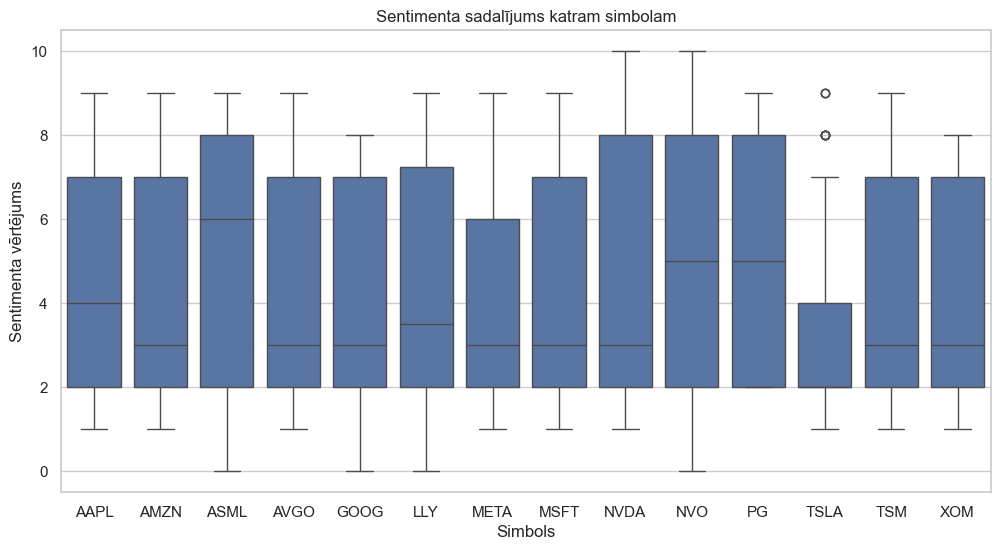

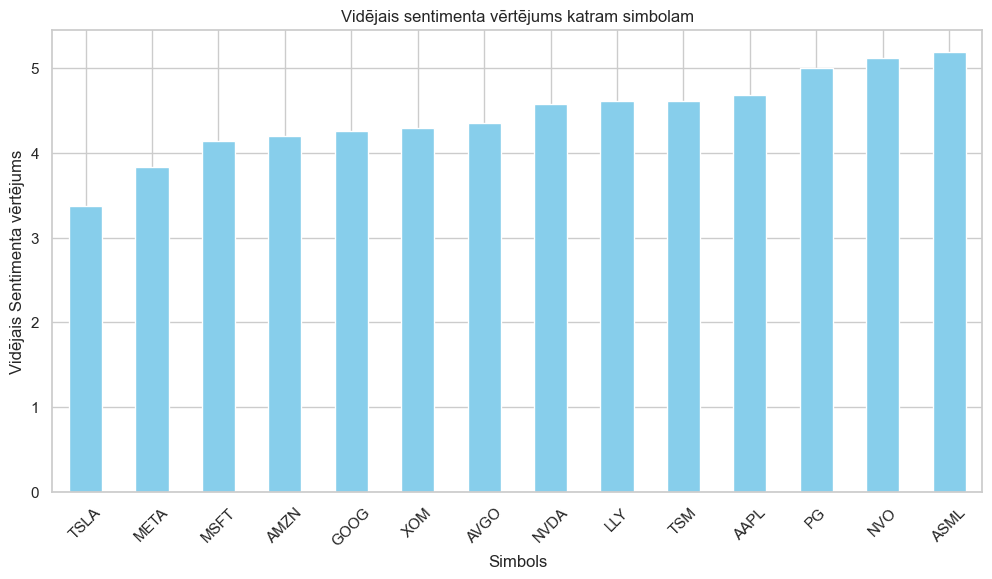

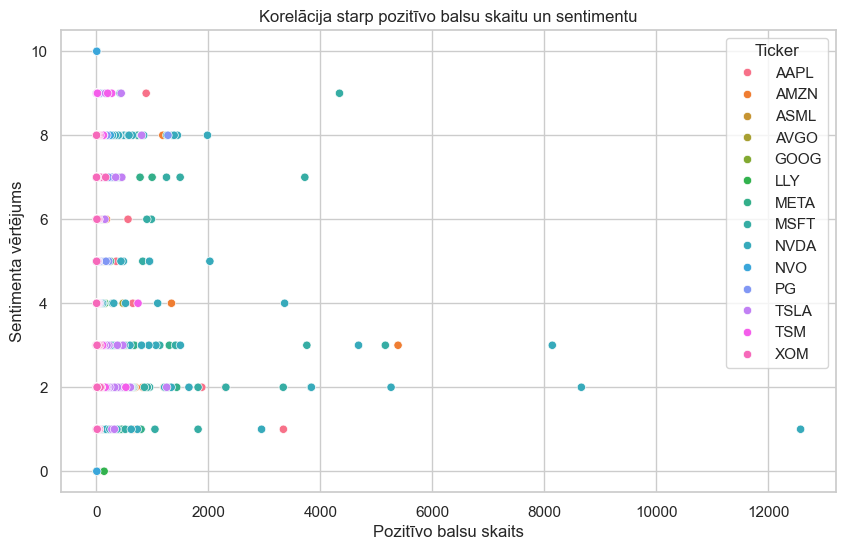

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Sentimenta sadalījums katram Ticker (Simbols)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Ticker', y='Sentiment', data=final_limited_df)
plt.title('Sentimenta sadalījums katram simbolam')
plt.xlabel('Simbols')
plt.ylabel('Sentimenta vērtējums')
plt.show()

# 2. Vidējais sentimenta vērtējums katram Ticker (Simbols)
plt.figure(figsize=(12, 6))
mean_sentiments = final_limited_df.groupby('Ticker')['Sentiment'].mean().sort_values()
mean_sentiments.plot(kind='bar', color='skyblue')
plt.title('Vidējais sentimenta vērtējums katram simbolam')
plt.xlabel('Simbols')
plt.ylabel('Vidējais Sentimenta vērtējums')
plt.xticks(rotation=45)
plt.show()

# 3. Korelācija starp Upvotes (Pozitīvo balsu skaits) un Sentimentu
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Upvotes', y='Sentiment', hue='Ticker', data=final_limited_df)
plt.title('Korelācija starp pozitīvo balsu skaitu un sentimentu')
plt.xlabel('Pozitīvo balsu skaits')
plt.ylabel('Sentimenta vērtējums')
plt.show()


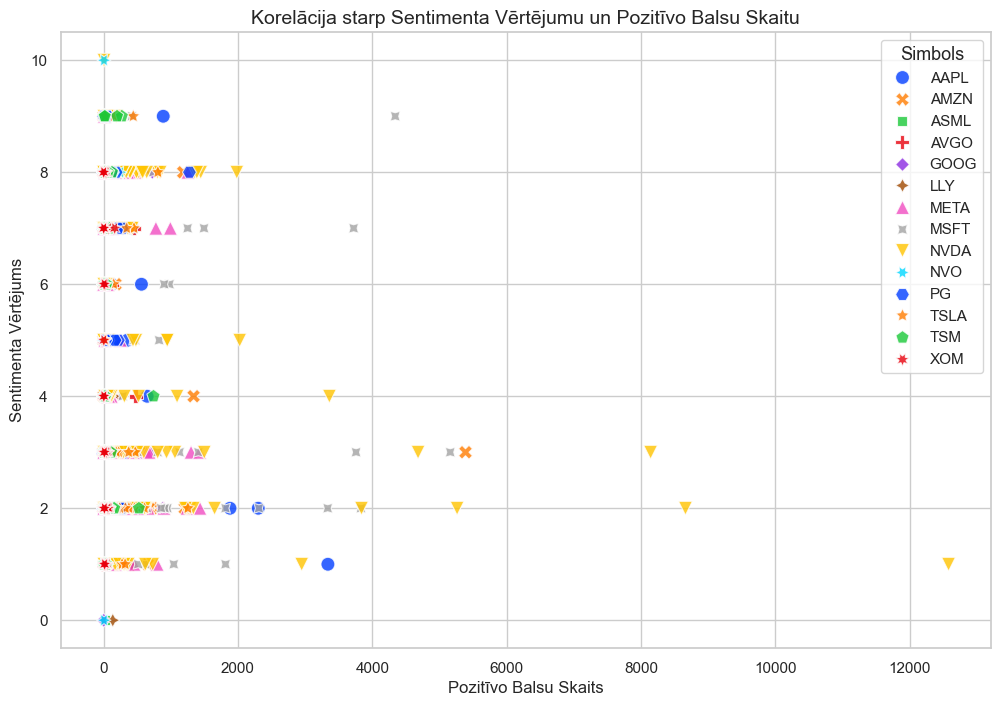

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pārveidojam 'Date' kolonnu par datetime objektu, ja tas vēl nav izdarīts
final_limited_df['Date'] = pd.to_datetime(final_limited_df.index)

# Uzstādam dizainu
sns.set(style="whitegrid")

# Uzzīmējam scatter plot ar Hue pēc 'Ticker', lai parādītu atšķirības starp uzņēmumiem
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(data=final_limited_df, x='Upvotes', y='Sentiment', hue='Ticker', style='Ticker', palette='bright', s=100, alpha=0.8)

# Uzliekam grafikam nosaukumus un etiķetes
plt.title('Korelācija starp Sentimenta Vērtējumu un Pozitīvo Balsu Skaitu', fontsize=14)
plt.xlabel('Pozitīvo Balsu Skaits', fontsize=12)
plt.ylabel('Sentimenta Vērtējums', fontsize=12)

# Parādām leģendu un grafiku
plt.legend(title='Simbols', title_fontsize='13', fontsize='11')
plt.grid(True)
plt.show()


In [70]:
final_limited_df

,Ticker,Text,Upvotes,Title,Sentiment,Date
0,AAPL,"Apple, buy the rights to NBA games. NBA league...",347,Apple (AAPL) to Spend Billions More on Enterta...,3.0,2023-03-28
1,AAPL,"Strategically speaking, this is smart and ""chu...",163,Apple (AAPL) to Spend Billions More on Enterta...,8.0,2023-03-28
2,AAPL,I think content creation is really there to ad...,109,Apple (AAPL) to Spend Billions More on Enterta...,8.0,2023-03-28
3,AAPL,That may be the end goal with the purchase of ...,87,Apple (AAPL) to Spend Billions More on Enterta...,7.0,2023-03-28
4,AAPL,"HBO is still the king, but I really enjoyed Se...",78,Apple (AAPL) to Spend Billions More on Enterta...,7.0,2023-03-28
...,...,...,...,...,...,...
1392,XOM,"Yes, that's correct. You're welcome!",4,"Exxon purchases Pioneer for $253 per share, bu...",5.0,2024-04-04
1393,XOM,"It's less to do with XOM's own moves, because ...",3,"Exxon purchases Pioneer for $253 per share, bu...",4.0,2024-04-04
1394,XOM,COP has pretty good dividends and has been on ...,2,"Exxon purchases Pioneer for $253 per share, bu...",8.0,2024-04-04
1395,XOM,">PXD holders won't receive cash, just stock in...",2,"Exxon purchases Pioneer for $253 per share, bu...",7.0,2024-04-04


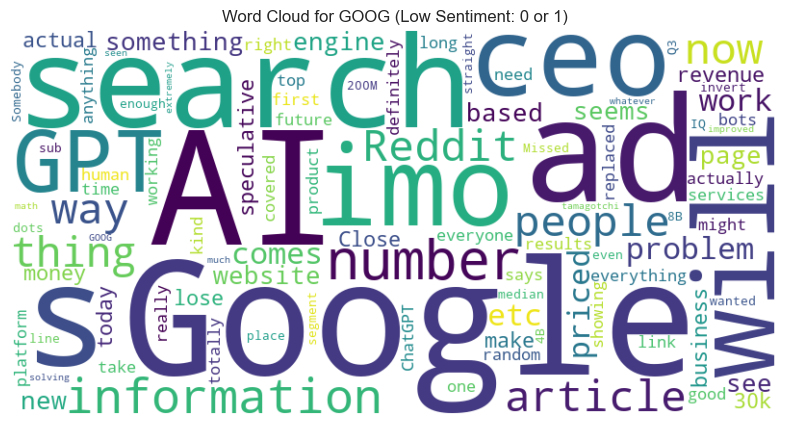

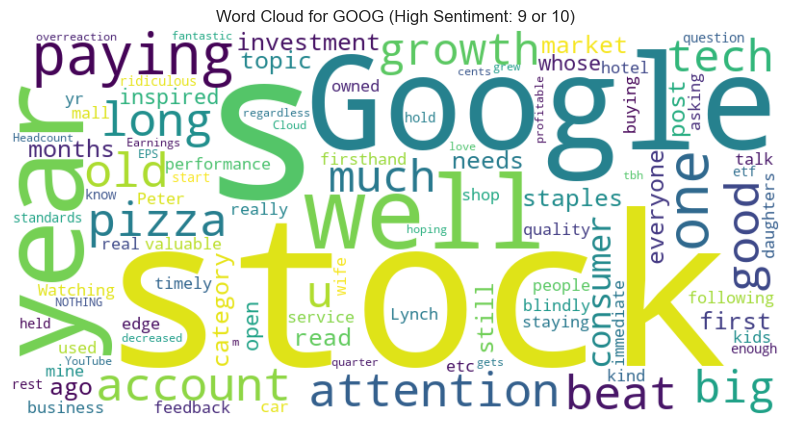

In [74]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Atlasām tikai GOOG simbola datus
goog_data = final_limited_df[final_limited_df['Ticker'] == 'GOOG']

# Atlasām datus ar zemākajiem sentimenta vērtējumiem (0 vai 1)
low_sentiment_texts = goog_data[goog_data['Sentiment'].isin([0, 2])]['Text']

# Atlasām datus ar augstākajiem sentimenta vērtējumiem (9 vai 10)
high_sentiment_texts = goog_data[goog_data['Sentiment'].isin([8, 10])]['Text']

def generate_wordcloud(texts, title):
    text = ' '.join(texts)  # Apvienojam visus tekstus vienā lielā virknē
    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Ģenerē vārdu mākoņus
generate_wordcloud(low_sentiment_texts, 'Word Cloud for GOOG (Low Sentiment: 0 or 1)')
generate_wordcloud(high_sentiment_texts, 'Word Cloud for GOOG (High Sentiment: 9 or 10)')


In [85]:
final_limited_df

,Ticker,Text,Upvotes,Title,Sentiment,Date
0,AAPL,"Apple, buy the rights to NBA games. NBA league...",347,Apple (AAPL) to Spend Billions More on Enterta...,3.0,2023-03-28
1,AAPL,"Strategically speaking, this is smart and ""chu...",163,Apple (AAPL) to Spend Billions More on Enterta...,8.0,2023-03-28
2,AAPL,I think content creation is really there to ad...,109,Apple (AAPL) to Spend Billions More on Enterta...,8.0,2023-03-28
3,AAPL,That may be the end goal with the purchase of ...,87,Apple (AAPL) to Spend Billions More on Enterta...,7.0,2023-03-28
4,AAPL,"HBO is still the king, but I really enjoyed Se...",78,Apple (AAPL) to Spend Billions More on Enterta...,7.0,2023-03-28
...,...,...,...,...,...,...
1392,XOM,"Yes, that's correct. You're welcome!",4,"Exxon purchases Pioneer for $253 per share, bu...",5.0,2024-04-04
1393,XOM,"It's less to do with XOM's own moves, because ...",3,"Exxon purchases Pioneer for $253 per share, bu...",4.0,2024-04-04
1394,XOM,COP has pretty good dividends and has been on ...,2,"Exxon purchases Pioneer for $253 per share, bu...",8.0,2024-04-04
1395,XOM,">PXD holders won't receive cash, just stock in...",2,"Exxon purchases Pioneer for $253 per share, bu...",7.0,2024-04-04


In [86]:
final_limited_df.reset_index(drop=True,inplace=True)
# final_limited_df['Date'] = pd.to_datetime(final_limited_df['Date'])
result = final_limited_df.groupby(['Date', 'Ticker'])['Sentiment'].agg(['mean', 'min', 'max'])

In [87]:
# Rename the columns
result.rename(columns={'mean': 'Reddit_sentiment_mean', 'min': 'Reddit_sentiment_min', 'max': 'Reddit_sentiment_max'}, inplace=True)

# Reset index to make 'Date' and 'Ticker' regular columns
result.reset_index(inplace=True)

In [91]:
result

,Date,Ticker,Reddit_sentiment_mean,Reddit_sentiment_min,Reddit_sentiment_max
0,2023-01-01,GOOG,7.400000,5.0,8.0
1,2023-01-03,META,2.600000,2.0,4.0
2,2023-01-08,AMZN,7.750000,7.0,8.0
3,2023-01-11,TSLA,3.000000,2.0,7.0
4,2023-01-12,TSM,5.400000,1.0,8.0
...,...,...,...,...,...
158,2024-04-04,TSLA,4.555556,2.0,8.0
159,2024-04-04,XOM,5.300000,3.0,8.0
160,2024-04-06,NVO,7.000000,2.0,9.0
161,2024-04-06,PG,5.857143,2.0,9.0


In [88]:
result[result.Ticker == "AAPL"]

,Date,Ticker,Reddit_sentiment_mean,Reddit_sentiment_min,Reddit_sentiment_max
13,2023-03-28,AAPL,6.600000,3.0,8.0
24,2023-09-19,AAPL,5.600000,2.0,8.0
46,2023-11-17,AAPL,5.900000,2.0,9.0
59,2023-12-09,AAPL,2.888889,1.0,6.0
61,2023-12-14,AAPL,4.555556,2.0,8.0
87,2024-02-01,AAPL,4.600000,2.0,8.0
97,2024-02-09,AAPL,4.500000,2.0,7.0
122,2024-03-05,AAPL,4.111111,2.0,9.0
144,2024-03-21,AAPL,4.500000,1.0,8.0
155,2024-04-03,AAPL,3.800000,1.0,7.0


In [97]:
result.Reddit_sentiment_max.value_counts()

Reddit_sentiment_max
8.0     86
9.0     41
7.0     18
6.0      8
4.0      3
5.0      2
2.0      2
10.0     2
3.0      1
Name: count, dtype: int64

C:\Users\new pc\AppData\Local\Temp\ipykernel_20976\3480187525.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Ticker', y='Reddit_sentiment_mean', data=result, palette='Set3')


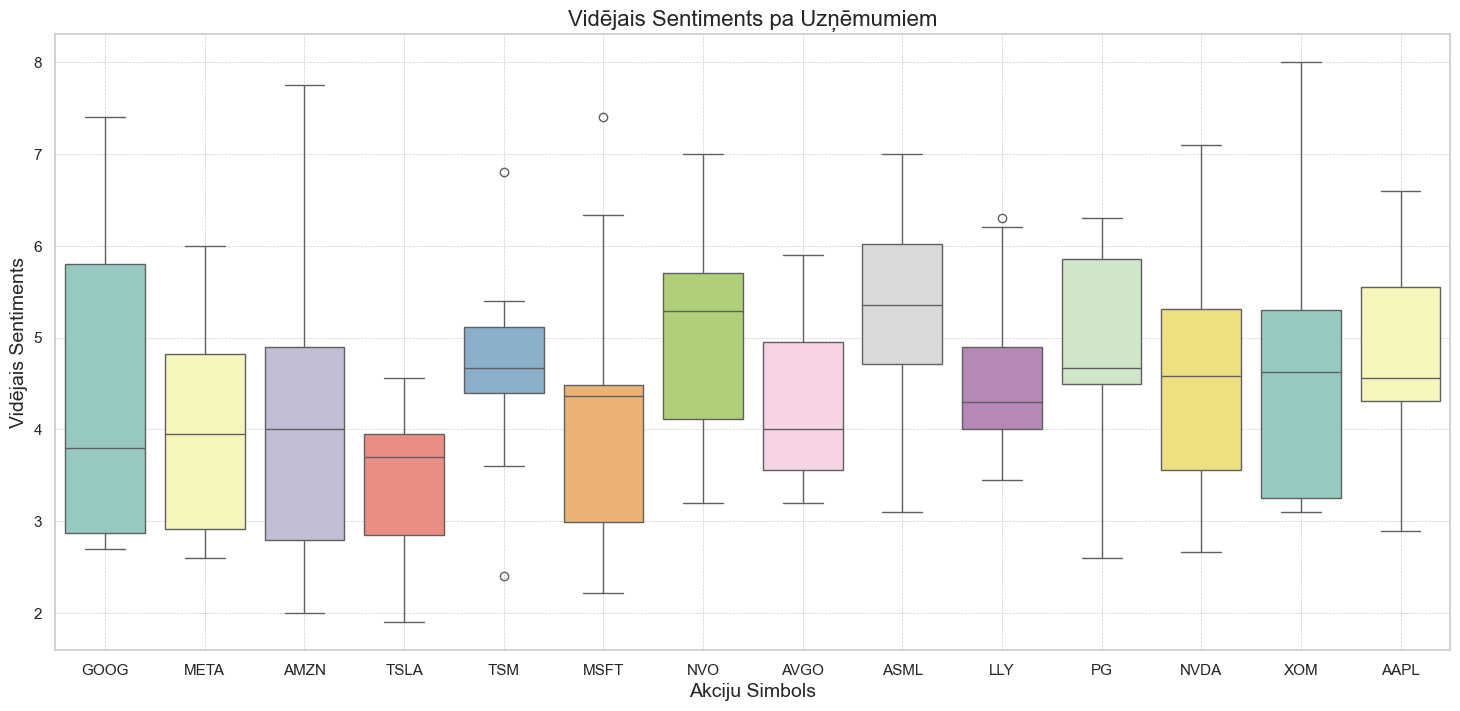

C:\Users\new pc\AppData\Local\Temp\ipykernel_20976\3480187525.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Ticker', y='Reddit_sentiment_min', data=result, palette='Set2')


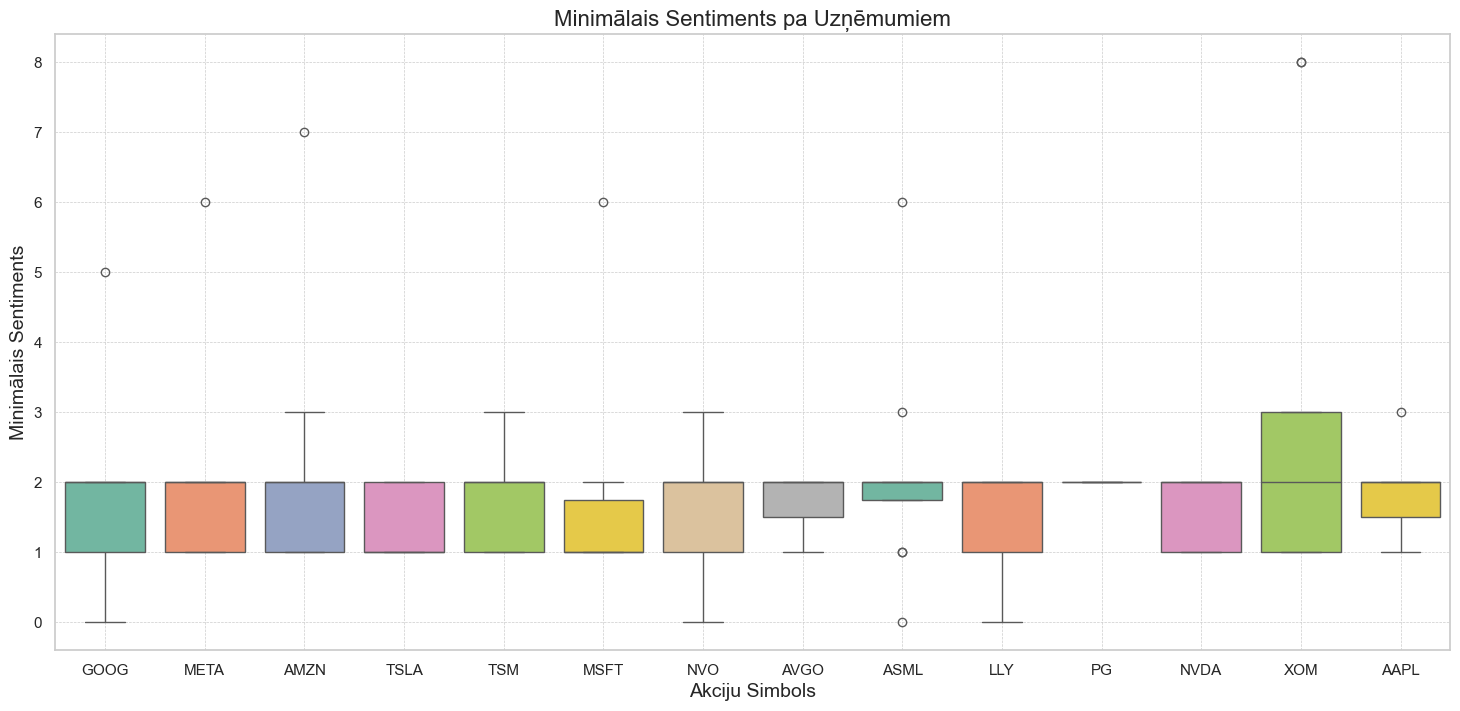

C:\Users\new pc\AppData\Local\Temp\ipykernel_20976\3480187525.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Ticker', y='Reddit_sentiment_max', data=result, palette='Set1')


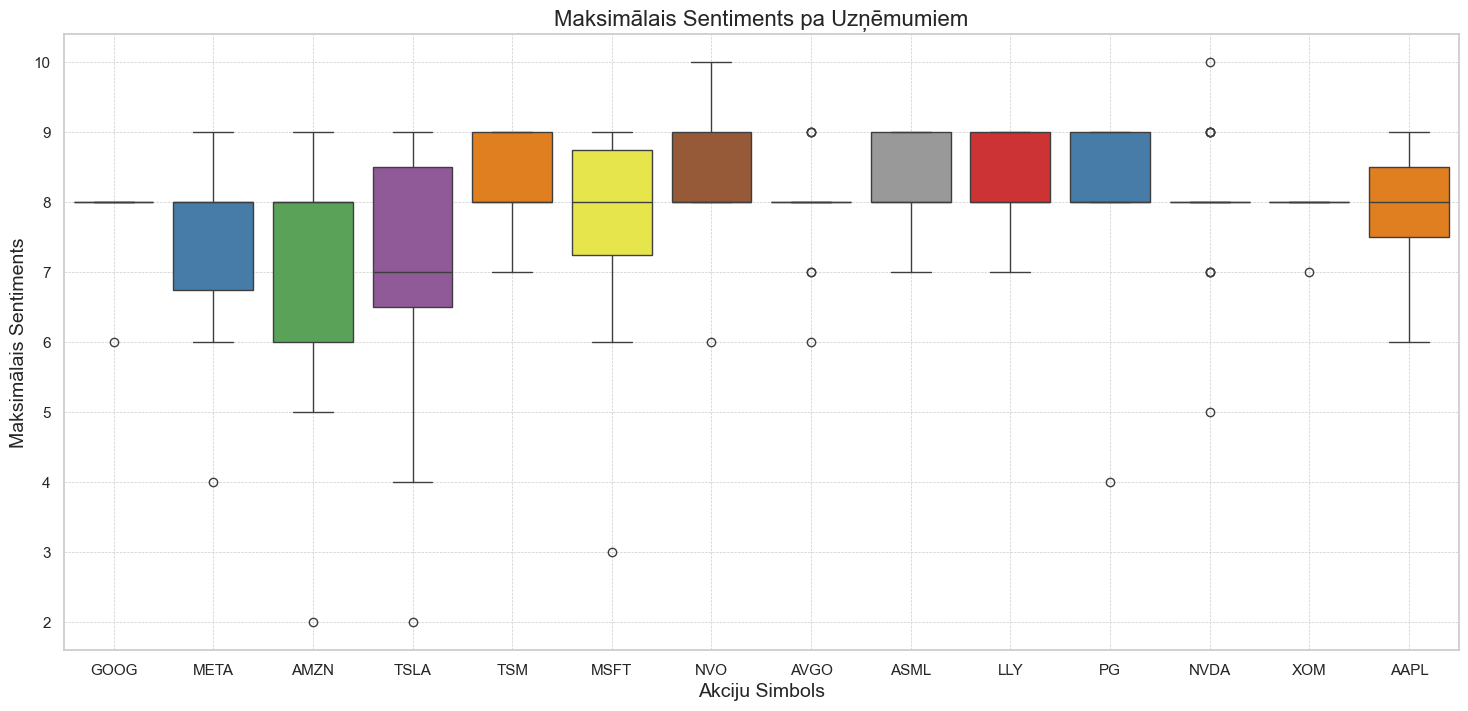

In [93]:
import seaborn as sns

result['Date'] = pd.to_datetime(result['Date'])

# Grafiku izveide
plt.figure(figsize=(18, 8))

# Boxplot parāda sentimenta izplatību katram Ticker
sns.boxplot(x='Ticker', y='Reddit_sentiment_mean', data=result, palette='Set3')
plt.title('Vidējais Sentiments pa Uzņēmumiem', fontsize=16)
plt.xlabel('Akciju Simbols', fontsize=14)
plt.ylabel('Vidējais Sentiments', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

# Lai iegūtu vairāk detalizētu informāciju, var izveidot papildus boxplotus par minimālo un maksimālo sentimentu
plt.figure(figsize=(18, 8))
sns.boxplot(x='Ticker', y='Reddit_sentiment_min', data=result, palette='Set2')
plt.title('Minimālais Sentiments pa Uzņēmumiem', fontsize=16)
plt.xlabel('Akciju Simbols', fontsize=14)
plt.ylabel('Minimālais Sentiments', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

plt.figure(figsize=(18, 8))
sns.boxplot(x='Ticker', y='Reddit_sentiment_max', data=result, palette='Set1')
plt.title('Maksimālais Sentiments pa Uzņēmumiem', fontsize=16)
plt.xlabel('Akciju Simbols', fontsize=14)
plt.ylabel('Maksimālais Sentiments', fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()



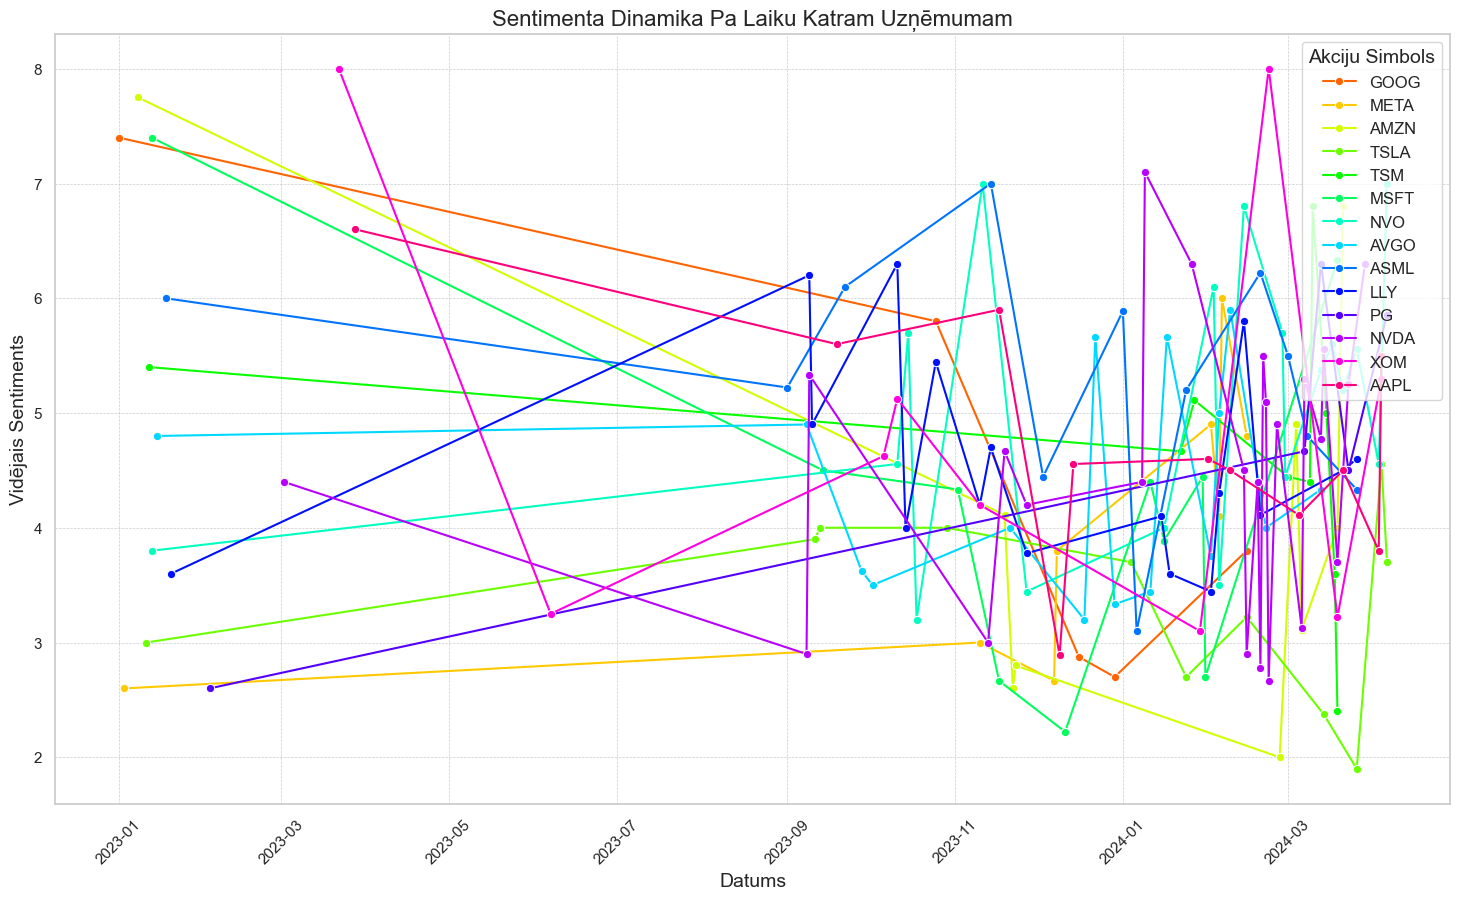

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pieņemot, ka jau ir sagatavots DataFrame ar nosaukumu `result`
result['Date'] = pd.to_datetime(result['Date'])

# Sagatavosim grafiku
plt.figure(figsize=(18, 10))

# Vizuāli atšķirīgi attēlosim katru uzņēmumu
palette = sns.color_palette("hsv", len(result['Ticker'].unique()))
sns.lineplot(x='Date', y='Reddit_sentiment_mean', hue='Ticker', data=result, palette=palette, marker='o')

# Grafika pielāgošana
plt.title('Sentimenta Dinamika Pa Laiku Katram Uzņēmumam', fontsize=16)
plt.xlabel('Datums', fontsize=14)
plt.ylabel('Vidējais Sentiments', fontsize=14)
plt.legend(title='Akciju Simbols', fontsize=12, title_fontsize=14, loc='upper right')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)  # Griež datuma etiķetes par 45 grādiem labākai lasāmībai

# Parāda grafiku
plt.show()


In [37]:
result.to_csv("Reddit_sentiment_grouped.csv", index=False)